In [ ]:
pip install pennylane --upgrade

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, RMSPropOptimizer
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
def generate_dataset(count):
    images = np.uint8(
        np.random.uniform(
            0,
            100,
            size=(count, 2, 4, 3),
            requires_grad=False
        )
    )
    labels = np.asarray(
        [np.random.randint(0, 2) for i in range(count)],
        requires_grad=False
    )
    # 0 - vertical
    # 1 - horizontal

    for i, label in enumerate(labels):
        if not(label):
            position = np.random.randint(0, 4)
            for row in [0, 1]:
                for ch in range(3):
                    images[i][row][position][ch] = 255
        else:
            row = np.random.randint(0, 2)
            row_position = np.random.randint(0, 3)
            for shift in [0, 1]:
                for ch in range(3):
                    images[i][row][row_position+shift][ch] = 255


    return images, labels


images, labels = generate_dataset(10)

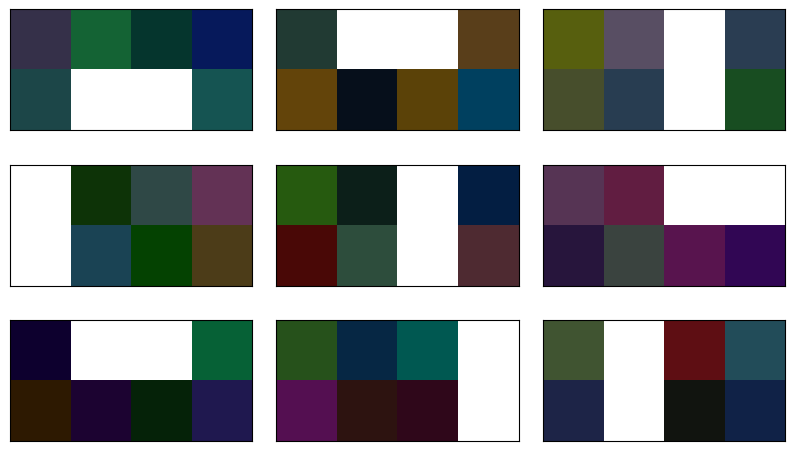

In [4]:
fig, ax = plt.subplots(3, 3, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(9):
    ax[i // 3, i % 3].imshow(
        images[i],
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)


In [5]:
dev = qml.device("lightning.qubit", wires=4)


def density_matrix(state):
    return state * np.conj(state).T


def upload_layer(image_part):
    for i, pixel in enumerate(image_part):
        qml.Rot(*pixel, wires=i)


def trainable_rotation(params):
    for i, rotation in enumerate(params):
        qml.Rot(*rotation, wires=i)


def entanglement_layer():
    qml.CNOT(wires=[2, 1])
    qml.CNOT(wires=[3, 1])
    qml.CNOT(wires=[3, 2])
    qml.CNOT(wires=[1, 0])
    qml.CNOT(wires=[2, 0])
    qml.CNOT(wires=[3, 0])


@qml.qnode(dev)
def qcirc(image, params, y):
    """
    image : (2, 4, 3)
    params: (2, 4, 3)
    """

    upload_layer(image[0])
    trainable_rotation(params[0])
    entanglement_layer()

    upload_layer(image[1])
    trainable_rotation(params[1])
    entanglement_layer()

    return qml.expval(qml.Hermitian(y, wires=[0]))

0.5460043757634021 0.4539956242365984


(<Figure size 1700x500 with 1 Axes>, <Axes: >)

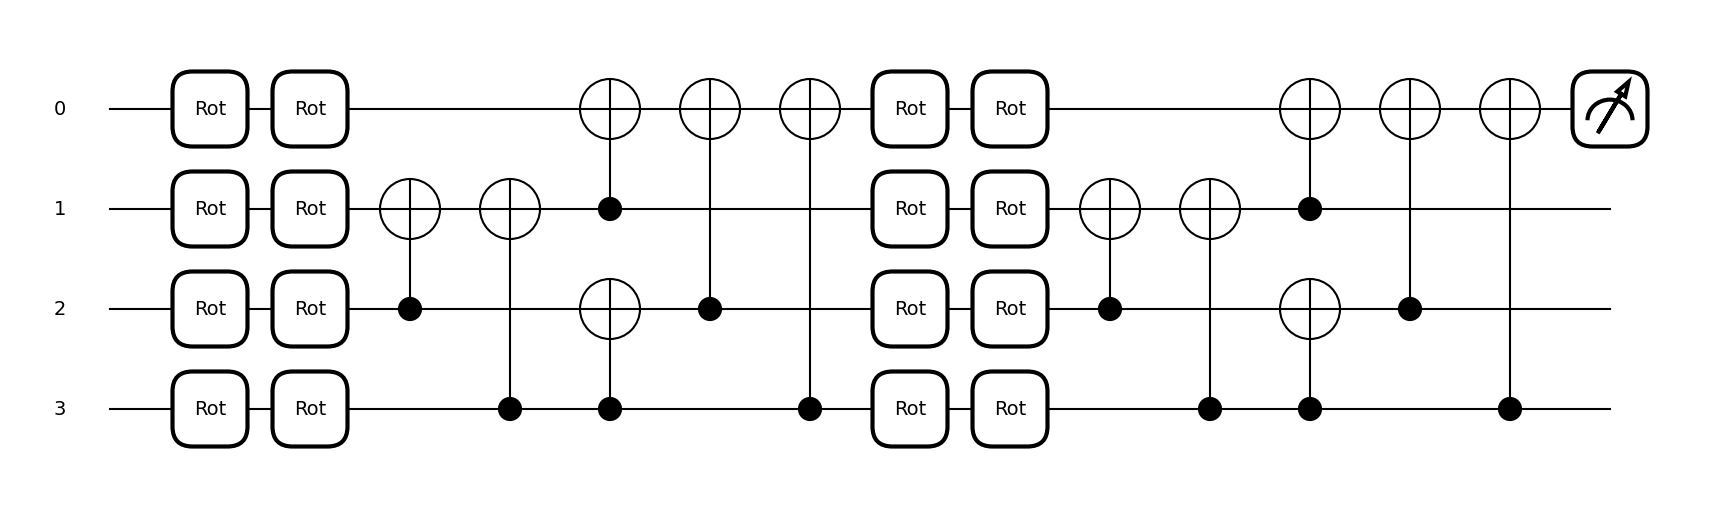

In [6]:
label_1 = [[1], [0]]
label_0 = [[0], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)



y1 = density_matrix(state_labels[0])
y2 = density_matrix(state_labels[1])
params = np.random.uniform(size=(2, 4, 3))
img = images[0]*(np.pi/255)

f1, f2 = qcirc(params, img, y1), qcirc(params, img, y2)
print(f1, f2)
qml.draw_mpl(qcirc)(img, params, y1)

In [7]:
from sklearn.metrics import accuracy_score, f1_score


def cost(params, images, y, state_labels=None, ansatz=qcirc):
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(images)):
        f = ansatz(params, images[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(images)



def get_batch(inputs, targets, batch_size):
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

In [8]:
def test(ansatz, params, x, y, state_labels=None):
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: ansatz(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)

    return np.array(predicted)

In [9]:
def plot_history(acc1, acc2):
    clear_output(wait=True)

    fig, axes = plt.subplots(1, 2, figsize=(30, 7), sharey=True)
    sns.set_style("whitegrid")
    k = list(range(1, len(acc1)+1))


    axes[0].set(xlabel='epochs', ylabel='train  f1-score')
    axes[1].set(xlabel='epochs', ylabel='test  f1-score')
    sns.lineplot(x=k, y=acc1, ax=axes[0])
    sns.lineplot(x=k, y=acc2, ax=axes[1])

    plt.show()


In [10]:
def train(epochs: int, batch_size: int,
          X_train: np.array, Y_train: np.array,
          X_test: np.array, Y_test: np.array,
          lr, ansatz, cost_func, test, params):

    opt = AdamOptimizer()
    train_f1_history, test_f1_history = [], []

    for it in range(epochs):
        for x, y in get_batch(X_train, Y_train, batch_size=batch_size):
            params, _, _, _ = opt.step(
                cost_func,
                params, x, y, state_labels,
                ansatz=qcirc
            )

        predicted_train = test(qcirc, params, X_train, Y_train, state_labels)
        f1_train = f1_score(Y_train, predicted_train, average="weighted")

        #loss = cost_func(params, X_train, Y_train, state_labels, ansatz=qcirc)

        predicted_test = test(qcirc, params, X_test, Y_test, state_labels)
        f1_test = f1_score(Y_test, predicted_test, average="weighted")


        train_f1_history.append(f1_train)
        test_f1_history.append(f1_test)


        plot_history(
            train_f1_history,
            test_f1_history
        )

    return (
        train_f1_history,
        test_f1_history
    )

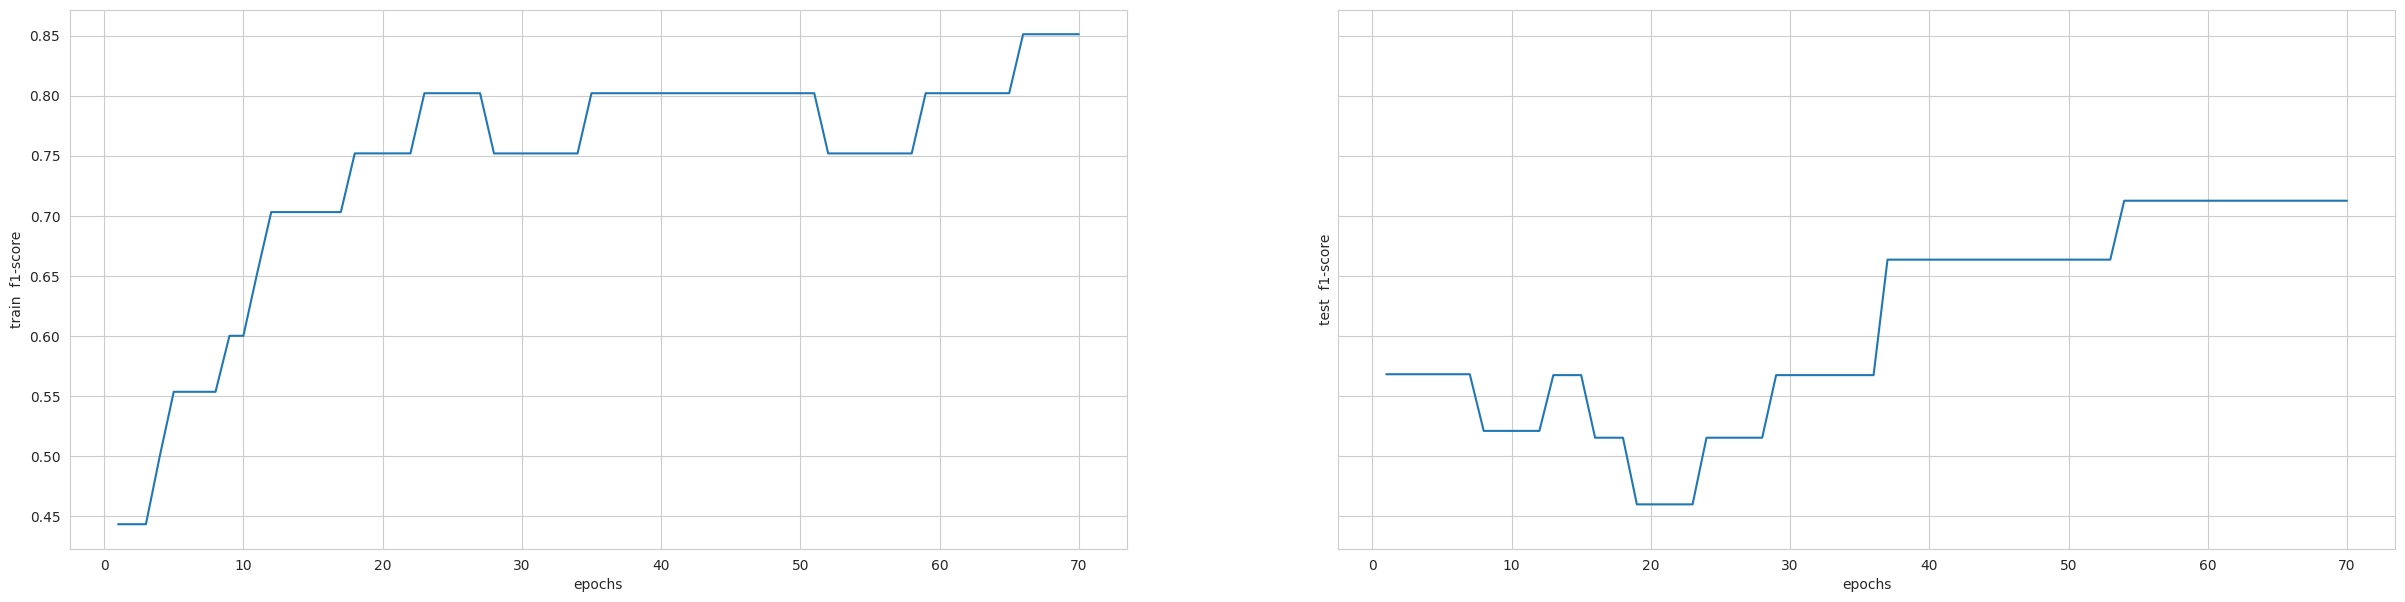

In [16]:
num_training = 40
data, labels = generate_dataset(num_training)

train_x, test_x, train_y, test_y = train_test_split(
    data,
    labels,
    train_size=0.5,
    random_state=422
)

learning_rate = 0.05
epochs = 70
batch_size = 5

train_f1, test_f1 = [], []


params = np.random.uniform(
    low=0.0,
    high=0.1,
    size=(2, 4, 3),
    requires_grad=True
)

train_f1, test_f1 = train(
    epochs, batch_size, train_x, train_y, test_x, test_y, learning_rate,
    qcirc, cost, test, params
)